# Notebook 1: Data Loading & Exploration

**Movie Recommendation System**  


Initial exploration of the MovieLens 25M dataset.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter
import os
import warnings
import json

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Setup & Load Data

In [2]:
# Setup paths
BASE_DIR = os.path.dirname(os.getcwd())
RAW_DIR = os.path.join(BASE_DIR, 'data', 'raw')
PROCESSED_DIR = os.path.join(BASE_DIR, 'data', 'processed')

os.makedirs(PROCESSED_DIR, exist_ok=True)

print(f"Current directory: {os.getcwd()}")
print(f"Project root: {BASE_DIR}")
print(f"Looking for data in: {RAW_DIR}")

# Load datasets
ratings = pd.read_csv(os.path.join(RAW_DIR, 'ratings.csv'))
movies = pd.read_csv(os.path.join(RAW_DIR, 'movies.csv'))
tags = pd.read_csv(os.path.join(RAW_DIR, 'tags.csv'))
links = pd.read_csv(os.path.join(RAW_DIR, 'links.csv'))

print(f"\nRatings: {ratings.shape[0]:,} rows")
print(f"Movies: {movies.shape[0]:,} rows")
print(f"Tags: {tags.shape[0]:,} rows")
print(f"Links: {links.shape[0]:,} rows")

Current directory: c:\Users\mhfou\Documents\MovieRecommenderSystem\notebooks
Project root: c:\Users\mhfou\Documents\MovieRecommenderSystem
Looking for data in: c:\Users\mhfou\Documents\MovieRecommenderSystem\data\raw

Ratings: 25,000,095 rows
Movies: 62,423 rows
Tags: 1,093,360 rows
Links: 62,423 rows


In [13]:
# View data structure
print("Ratings:")
display(ratings.head())
print("\nMovies:")
display(movies.head())
print("\nTags:")
display(tags.head())
print("\nLinks (IMDB/TMDB IDs):")
display(links.head())

Ratings:


,userId,movieId,rating,timestamp,datetime,year
0,1,296,5.00,1147880044,2006-05-17 15:34:04,2006
1,1,306,3.50,1147868817,2006-05-17 12:26:57,2006
2,1,307,5.00,1147868828,2006-05-17 12:27:08,2006
3,1,665,5.00,1147878820,2006-05-17 15:13:40,2006
4,1,899,3.50,1147868510,2006-05-17 12:21:50,2006



Movies:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy



Tags:


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455



Links (IMDB/TMDB IDs):


,movieId,imdbId,tmdbId
0,1,114709,862.00
1,2,113497,8844.00
2,3,113228,15602.00
3,4,114885,31357.00
4,5,113041,11862.00


## 2. Dataset Statistics

In [4]:
# Calculate key metrics
n_ratings = len(ratings)
n_users = ratings['userId'].nunique()
n_movies = ratings['movieId'].nunique()
matrix_size = n_users * n_movies
sparsity = (1 - n_ratings / matrix_size) * 100

print(f"Total ratings: {n_ratings:,}")
print(f"Unique users: {n_users:,}")
print(f"Unique movies: {n_movies:,}")
print(f"Matrix sparsity: {sparsity:.2f}%")
print(f"\nMean rating: {ratings['rating'].mean():.2f}")
print(f"Median rating: {ratings['rating'].median():.2f}")
print(f"\nRating distribution:")
print(ratings['rating'].value_counts().sort_index())

Total ratings: 25,000,095
Unique users: 162,541
Unique movies: 59,047
Matrix sparsity: 99.74%

Mean rating: 3.53
Median rating: 3.50

Rating distribution:
rating
0.50     393068
1.00     776815
1.50     399490
2.00    1640868
2.50    1262797
3.00    4896928
3.50    3177318
4.00    6639798
4.50    2200539
5.00    3612474
Name: count, dtype: int64


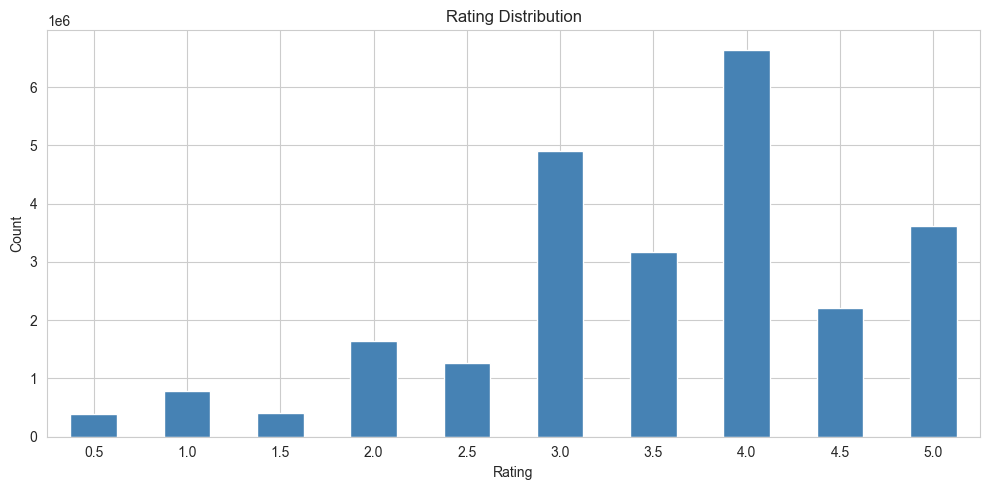

In [5]:
# Visualize rating distribution
plt.figure(figsize=(10, 5))
ratings['rating'].value_counts().sort_index().plot(kind='bar', color='steelblue')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 3. User & Movie Activity

In [5]:
# User and movie statistics
user_counts = ratings.groupby('userId').size()
movie_counts = ratings.groupby('movieId').size()

print("User activity:")
print(user_counts.describe())
print(f"\nMovie popularity:")
print(movie_counts.describe())

User activity:
count   162541.00
mean       153.81
std        268.05
min         20.00
25%         36.00
50%         71.00
75%        162.00
max      32202.00
dtype: float64

Movie popularity:
count   59047.00
mean      423.39
std      2477.89
min         1.00
25%         2.00
50%         6.00
75%        36.00
max     81491.00
dtype: float64


In [6]:
# Top 10 most rated movies
top_movies = movie_counts.nlargest(10)
movie_titles = movies.set_index('movieId')['title']

print("Top 10 most rated movies:")
for i, (movie_id, count) in enumerate(top_movies.items(), 1):
    print(f"{i:2d}. {movie_titles[movie_id]:45s} {count:>6,}")

Top 10 most rated movies:
 1. Forrest Gump (1994)                           81,491
 2. Shawshank Redemption, The (1994)              81,482
 3. Pulp Fiction (1994)                           79,672
 4. Silence of the Lambs, The (1991)              74,127
 5. Matrix, The (1999)                            72,674
 6. Star Wars: Episode IV - A New Hope (1977)     68,717
 7. Jurassic Park (1993)                          64,144
 8. Schindler's List (1993)                       60,411
 9. Braveheart (1995)                             59,184
10. Fight Club (1999)                             58,773


## 4. Genre Analysis

In [7]:
# Extract and count genres
all_genres = []
for genres in movies['genres']:
    if genres != '(no genres listed)':
        all_genres.extend(genres.split('|'))

genre_counts = Counter(all_genres)

print(f"Total unique genres: {len(genre_counts)}")
print(f"\nTop 10 genres:")
for genre, count in genre_counts.most_common(10):
    print(f"{genre:15s}: {count:>5,} ({count/len(movies)*100:5.1f}%)")

Total unique genres: 19

Top 10 genres:
Drama          : 25,606 ( 41.0%)
Comedy         : 16,870 ( 27.0%)
Thriller       : 8,654 ( 13.9%)
Romance        : 7,719 ( 12.4%)
Action         : 7,348 ( 11.8%)
Horror         : 5,989 (  9.6%)
Documentary    : 5,605 (  9.0%)
Crime          : 5,319 (  8.5%)
Adventure      : 4,145 (  6.6%)
Sci-Fi         : 3,595 (  5.8%)


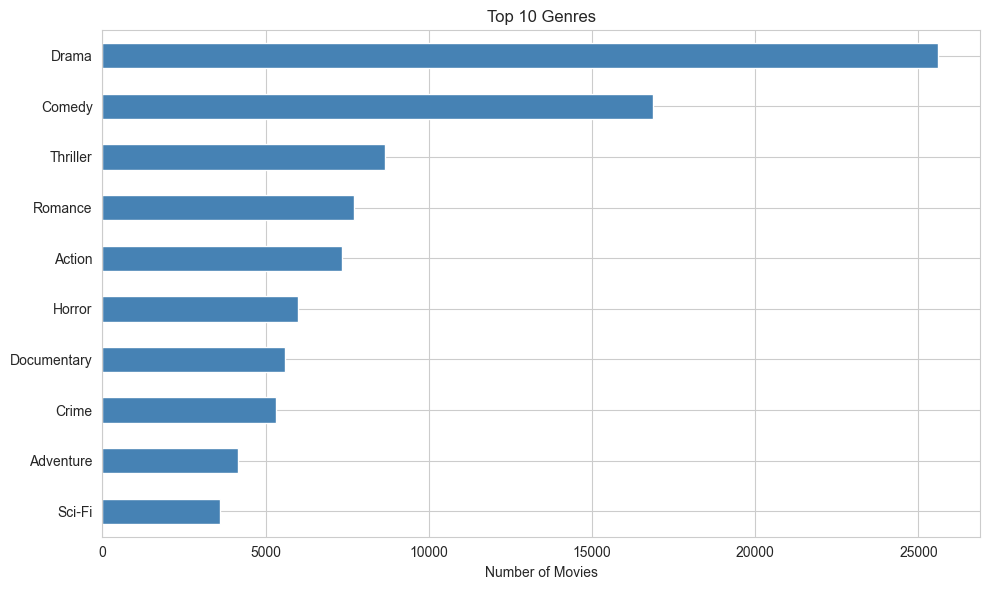

In [9]:
# Visualize top genres
top_genres = pd.Series(dict(genre_counts.most_common(10)))

plt.figure(figsize=(10, 6))
top_genres.plot(kind='barh', color='steelblue')
plt.title('Top 10 Genres')
plt.xlabel('Number of Movies')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 5. Tag Analysis

In [8]:
# Tag statistics
print(f"Total tags: {len(tags):,}")
print(f"Unique tags: {tags['tag'].nunique():,}")
print(f"Movies with tags: {tags['movieId'].nunique():,}")
print(f"\nTop 15 tags:")
print(tags['tag'].value_counts().head(15))

Total tags: 1,093,360
Unique tags: 73,050
Movies with tags: 45,251

Top 15 tags:
tag
sci-fi                8330
atmospheric           6516
action                5907
comedy                5702
surreal               5326
based on a book       5079
twist ending          4820
funny                 4738
visually appealing    4526
dystopia              4257
dark comedy           4026
BD-R                  3966
thought-provoking     3844
romance               3791
stylized              3728
Name: count, dtype: int64


## 6. Temporal Patterns

In [9]:
# Convert timestamps and extract time features
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings['year'] = ratings['datetime'].dt.year

print(f"Date range: {ratings['datetime'].min()} to {ratings['datetime'].max()}")
print(f"Years covered: {ratings['year'].max() - ratings['year'].min() + 1}")

Date range: 1995-01-09 11:46:49 to 2019-11-21 09:15:03
Years covered: 25


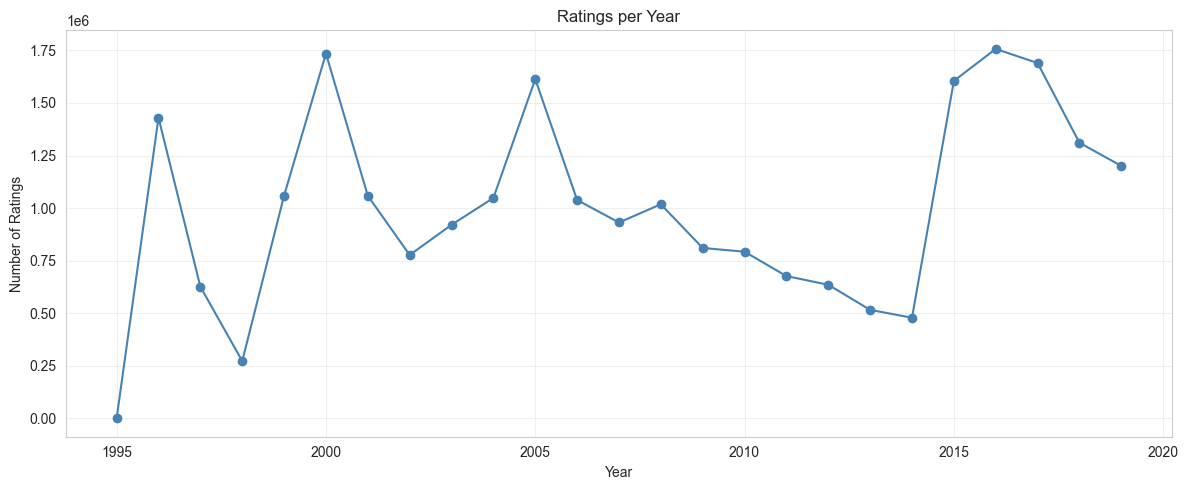

In [12]:
# Yearly trends
yearly = ratings.groupby('year').size()

plt.figure(figsize=(12, 5))
yearly.plot(kind='line', marker='o', color='steelblue')
plt.title('Ratings per Year')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Data Quality

In [10]:
# Quality checks
print("Missing values:")
print(f"Ratings: {ratings.isnull().sum().sum()}")
print(f"Movies: {movies.isnull().sum().sum()}")
print(f"Tags: {tags.isnull().sum().sum()}")

print(f"\nDuplicate ratings: {ratings.duplicated(subset=['userId', 'movieId']).sum()}")
print(f"Invalid ratings: {((ratings['rating'] < 0.5) | (ratings['rating'] > 5)).sum()}")
print(f"Movies without genres: {(movies['genres'] == '(no genres listed)').sum()}")

Missing values:
Ratings: 0
Movies: 0
Tags: 16

Duplicate ratings: 0
Invalid ratings: 0
Movies without genres: 5062


## 8. Summary

In [11]:
# Create and save summary
summary = {
    'total_ratings': int(n_ratings),
    'unique_users': int(n_users),
    'unique_movies': int(n_movies),
    'sparsity_percent': float(sparsity),
    'mean_rating': float(ratings['rating'].mean()),
    'unique_genres': int(len(genre_counts)),
    'unique_tags': int(tags['tag'].nunique()),
    'date_range': f"{ratings['datetime'].min()} to {ratings['datetime'].max()}"
}

# Save to JSON
with open(os.path.join(PROCESSED_DIR, 'dataset_summary.json'), 'w') as f:
    json.dump(summary, f, indent=2, default=str)

# Print key findings
print("KEY FINDINGS:")
print(f"- {n_ratings:,} ratings from {n_users:,} users on {n_movies:,} movies")
print(f"- Matrix sparsity: {sparsity:.2f}% (high cold-start challenge)")
print(f"- Mean rating: {ratings['rating'].mean():.2f}/5.0")
print(f"- {len(genre_counts)} genres, {tags['tag'].nunique():,} unique tags")
print(f"- Dataset spans {ratings['year'].max() - ratings['year'].min() + 1} years")
print(f"- Data quality: Excellent (no missing values or duplicates)")
print(f"\nReady for preprocessing and feature engineering.")

KEY FINDINGS:
- 25,000,095 ratings from 162,541 users on 59,047 movies
- Matrix sparsity: 99.74% (high cold-start challenge)
- Mean rating: 3.53/5.0
- 19 genres, 73,050 unique tags
- Dataset spans 25 years
- Data quality: Excellent (no missing values or duplicates)

Ready for preprocessing and feature engineering.
